In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import kruskal

In [2]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES = "../data/driver_genes"
GENE_EXP_DATA = "../data/datasets/PCAWG/gene_expression/tophat_star_fpkm.v2_aliquot_gl.tsv"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
ID_MAP = "../data/datasets/PCAWG/misc/tumor_id_mappings.tsv"
GENE_NAME_MAP = "../data/ref/gene_mappings.tsv"
CANCER_GENE_TYPES = "../metadata/cancer_genes.tsv"

# output files
RESULTS_DIR = "../results/PCAWG/TF_expression_analysis"
os.makedirs(RESULTS_DIR, exist_ok=True)
PLOT_DATA_DIR = "../plot_data/TFBS_Fabian"
os.makedirs(PLOT_DATA_DIR, exist_ok=True)

In [3]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [4]:
# genome-wide mutations
genome_wide_mutations = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")

In [5]:
# get rna-seq id corresponding to tumor sample id 
id_map_df = pd.read_csv(ID_MAP, sep="\t")
id_map_df = id_map_df[["tumor_wgs_aliquot_id", "tumor_rna_seq_aliquot_id"]]
id_map_df.rename(columns={"tumor_wgs_aliquot_id": "Tumor_Sample_Barcode"}, inplace=True)
id_map_df.drop_duplicates(inplace=True)
print(id_map_df.shape)
id_map_df.dropna(inplace=True)
print(id_map_df.shape)

(2834, 2)
(1284, 2)


In [6]:
# get gene expression data for tumor samples
gene_exp_df = pd.read_csv(GENE_EXP_DATA, sep="\t", index_col=0).T.reset_index()
gene_exp_df.rename({"index": "tumor_rna_seq_aliquot_id"}, axis=1, inplace=True)
gene_exp_df.set_index("tumor_rna_seq_aliquot_id", inplace=True)
print(gene_exp_df.shape)
gene_exp_df = gene_exp_df.merge(id_map_df, on="tumor_rna_seq_aliquot_id", how="inner")
print(gene_exp_df.shape)
tumor_list = gene_exp_df["Tumor_Sample_Barcode"].unique().tolist()
gene_exp_df = gene_exp_df[gene_exp_df["Tumor_Sample_Barcode"].isin(tumor_list)]
print(gene_exp_df["Tumor_Sample_Barcode"].nunique())

(1521, 57820)
(1267, 57822)
1267


In [7]:
# get gene name mapping from ensembl gene id to hgnc symbol
gene_name_map_df = pd.read_csv(GENE_NAME_MAP, sep="\t")
gene_name_map_df = gene_name_map_df[["ensembl_gene_id", "hgnc_symbol"]]
print(gene_name_map_df.shape)
gene_name_map_df.dropna(inplace=True)
print(gene_name_map_df.shape)
gene_name_map_df.drop_duplicates(inplace=True)
print(gene_name_map_df.shape)
gene_name_map = dict(zip(gene_name_map_df["ensembl_gene_id"], gene_name_map_df["hgnc_symbol"]))
print(len(gene_name_map), list(gene_name_map.items())[:5])
# rename columns
gene_exp_df.columns = gene_exp_df.columns.str.split(".").str[0]
gene_exp_df.rename(columns=gene_name_map, inplace=True)
print(gene_exp_df.shape)

(278276, 2)
(241392, 2)
(46525, 2)
46522 [('ENSG00000210049', 'MT-TF'), ('ENSG00000211459', 'MT-RNR1'), ('ENSG00000210077', 'MT-TV'), ('ENSG00000210082', 'MT-RNR2'), ('ENSG00000209082', 'MT-TL1')]
(1267, 57822)


In [8]:
# selected TFs
selected_tfs = {
    "Skin-Melanoma": ["ZNF384", "HSF2", "BHLHE41", "STAT5B", "IRF6", "GZF1"],
    "Lymph-BNHL": ["NKX2-1", "ME2", "BHLHE41", "SSBP3", "TCF4", "FHL2", "MEF2B", "ZNF582"],
}

In [14]:
# get all mutations in driver genes
cancer_type = "Lymph-BNHL"  # specify cancer type here
# cancer_type = "Skin-Melanoma"  # specify cancer type here
mut_df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
driver_genes = pd.read_csv(os.path.join(DRIVER_GENES, cancer_type + ".tsv"), sep="\t")
driver_genes_list = driver_genes["gene"].tolist()
mut_df = mut_df[mut_df["gene"].isin(driver_genes_list)]
mut_df = pd.merge(mut_df, driver_genes[["gene", "gene_length"]], on="gene", how="left")
print(mut_df.shape)
# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(mut_df.shape)
# samples list
tumor_samples = mut_df["Tumor_Sample_Barcode"].unique().tolist()
print(f"Number of tumor samples with driver mutations in {cancer_type}: {len(tumor_samples)}")

(3036, 14)
(3036, 14)
Number of tumor samples with driver mutations in Lymph-BNHL: 104


In [15]:
# get gene expression data for tumor samples of selected cancer type
gene_exp_selected_df = gene_exp_df[gene_exp_df["Tumor_Sample_Barcode"].isin(tumor_samples)]
print(gene_exp_selected_df.shape)
# genes for TFs most differentially disrupted by passengers in the absence of drivers in Skin-Melanoma
gene_exp_selected_df = gene_exp_selected_df[selected_tfs[cancer_type]]
print(gene_exp_selected_df.shape)

(102, 57822)
(102, 8)


In [16]:
# get summary stats for each TF
tf_summary_list = []
for tf in gene_exp_selected_df.columns:
    expr_values = gene_exp_selected_df[[tf]].copy()
    expr_values.rename(columns={tf: "expression"}, inplace=True)
    # get summary stats
    expr_values_summary = {
        "TF": tf,
        "mean_expression": expr_values["expression"].mean(),
        "median_expression": expr_values["expression"].median(),
        "num_samples": expr_values.shape[0],
        "num_zero_expression": (expr_values["expression"] == 0).sum(),
        "num_nonzero_expression": (expr_values["expression"] > 0).sum(),
    }
    tf_summary_list.append(expr_values_summary)
tf_summary_df = pd.DataFrame(tf_summary_list)
print(tf_summary_df.shape)

(8, 6)


/Users/an36943/miniforge3/envs/cancer-model/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


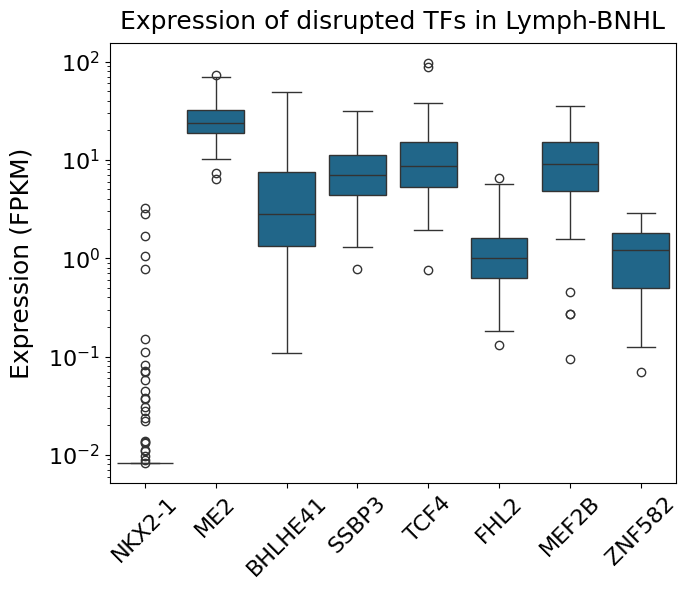

In [17]:
# plot expression distributions for each TF
melted_expr_df = gene_exp_selected_df.melt(var_name="TF", value_name="Expression")
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]

plt.figure(figsize=(7, 6))
sns.boxplot(
    data=melted_expr_df, 
    x="TF", 
    y="Expression", 
    log_scale=True,
    color=colors[1]
)
plt.xlabel("", fontsize=16, labelpad=10)
plt.xticks(fontsize=16, rotation=45)
plt.ylabel("Expression (FPKM)", fontsize=18, labelpad=10)
plt.yticks(fontsize=16)
plt.title(f"Expression of disrupted TFs in {cancer_type}", fontsize=18, pad=10)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/{cancer_type}_TF_expression_boxplot.png", dpi=300)

# source data
melted_expr_df.to_csv(f"{PLOT_DATA_DIR}/{cancer_type}_TF_expression_boxplot_data.tsv", sep="\t", index=False)